In [2]:
import numpy as np
from collections import Counter
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
LAMBDA = 0.5
T = 10

In [4]:
def poisson_process(lambda_, time_border):
    """
    Args:
    lambda_ - интенсивность потока
    time_border - ограничение интервала времени
    
    Output:
    s_k - список моментов времени получения нового вызова в системе
    
    """
    t, k = 0, 0
    s_k = []
    u = np.random.uniform
    while t<time_border:
        r = u()
        t = t -np.log(r)/lambda_ 
        if t>T:
            return s_k    
        k+=1
        s_k.append(t)   
    return s_k 

In [5]:
def plot_example(x):
    fig = plt.figure(figsize=(6,4))
    plt.step(range(len(x)), np.array(res).cumsum(), color='blue', alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [11]:
res

[1.0152557160780256, 4.890707981266199, 5.729884779066724, 7.443651606946369]

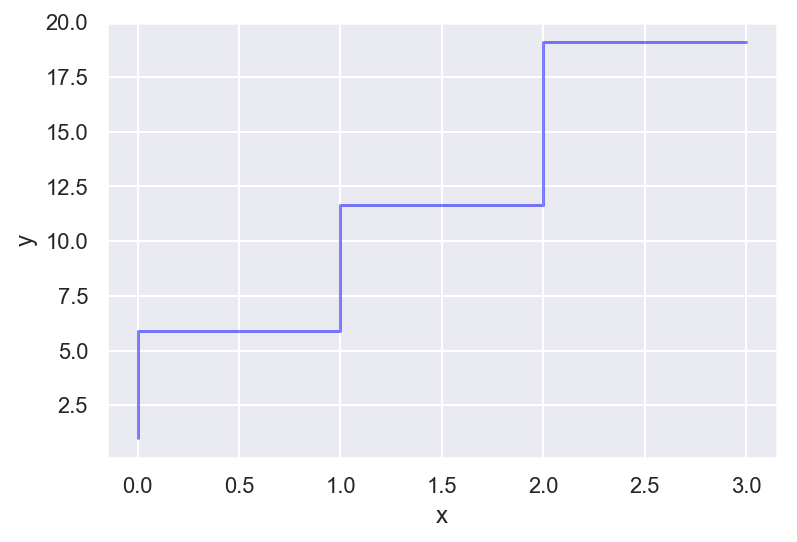

In [10]:
res = poisson_process(lambda_=LAMBDA, 
                      time_border=T)
plot_example(res)

#### Генерация значений в матрице с корзинами

In [16]:
def gen_poisson_multiple(n, lambda_, time_border):
    """
    Args:
    n - количество списков моментов времени получения нового вызовы в системе
    lambda_ - интенсивность потока
    time_border - ограничение интервала времени
    
    Output:
    s_k - список из списков моментов времени получения нового вызова в системе
    
    """
    return list(map(poisson_process, np.repeat(lambda_, n), np.repeat(time_border, n)))

In [17]:
def claims_to_bins(time_border, res, bins_multiple, return_bins=False):
    """
    Args:
    time_border - ограничение интервала времени
    res - список моментов времени получения нового вызовы в системе
    bins_multiple - множитель для time_border для создания количества корзин
    
    Output:
    s_k - список из списков моментов времени получения нового вызовы в системе
    
    """
    # Массив с корзинами
    bins = np.linspace(0, time_border, time_border*bins_multiple) #  l <=x< h
    # Индексы значений по корзинам
    inds = np.digitize(res, bins)
    # Общий подсчет значений по корзинам
    c = Counter(inds)
    # Дополняем словарь корзинами с пустым количеством вхождений
    c_new = {}
    for x in range(time_border*bins_multiple):
        c_new[x] = 0
    for k, v in c.items():
        c_new[k] = v
    #  Получаем значения количества вхождений относительно корзин
    v = np.array([c_new[x] for x in range(time_border*bins_multiple)])
    
    # Возвращаем вхождения и разметку по корзинам
    if return_bins:
        return v, bins
    else:
        return v

In [18]:
def get_claims_indicies(n, time_border, poisson_vecs, bins_multiple):
    """
    Args:
    n - количество генерируемых процессов
    time_border - ограничение интервала времени
    poisson_vecs - список из списков моментов времени получения нового вызова в системе
    bins_multiple - множитель для time_border для создания количества корзин
    
    Output:
    массив из выходов функции claims_to_bins, без bins
    
    """
    return np.array(list((map(claims_to_bins, 
                         np.repeat(time_border,n),
                         poisson_vecs,
                         np.repeat(bins_multiple, n)))))

In [19]:
def get_claims_and_bins(n, time_border, poisson_vecs, bins_multiple):
    """
    Обертка для get_claims_indicies.
    
    Output:
    1. массив из выходов функции claims_to_bins, без bins
    2. разметка интервалов по корзинам
    """
    v = get_claims_indicies(n, time_border, poisson_vecs, bins_multiple)
    bins = np.linspace(0, time_border, time_border*bins_multiple)
    return v, bins

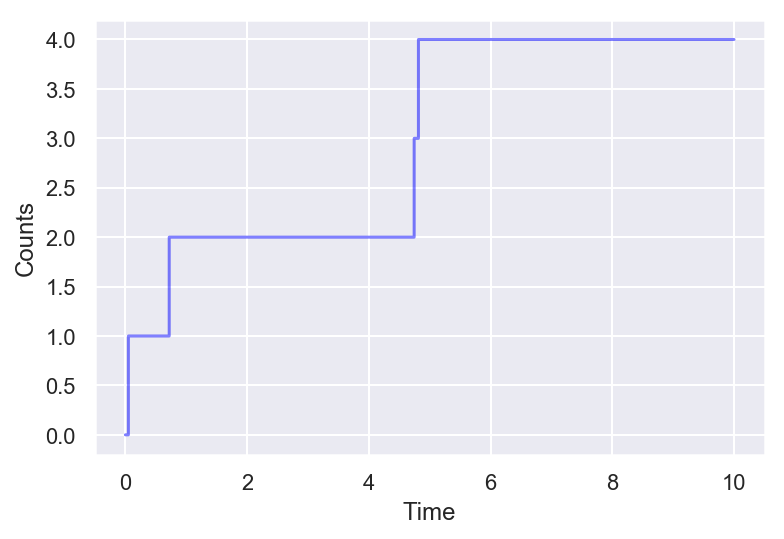

In [20]:
res = gen_poisson_multiple(n=1, 
                           lambda_=LAMBDA,
                           time_border=T)[0]
v, bins = claims_to_bins(time_border=T,
                         res=res,
                         bins_multiple=100,
                         return_bins=True)

plt.step(bins, v.cumsum(), color='blue', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

---

In [21]:
res = gen_poisson_multiple(n=10, 
                           lambda_=LAMBDA,
                           time_border=T)

v, bins = get_claims_and_bins(n=10, 
                              time_border=T, 
                              poisson_vecs=res,
                              bins_multiple=100)

In [22]:
v.shape

(10, 1000)

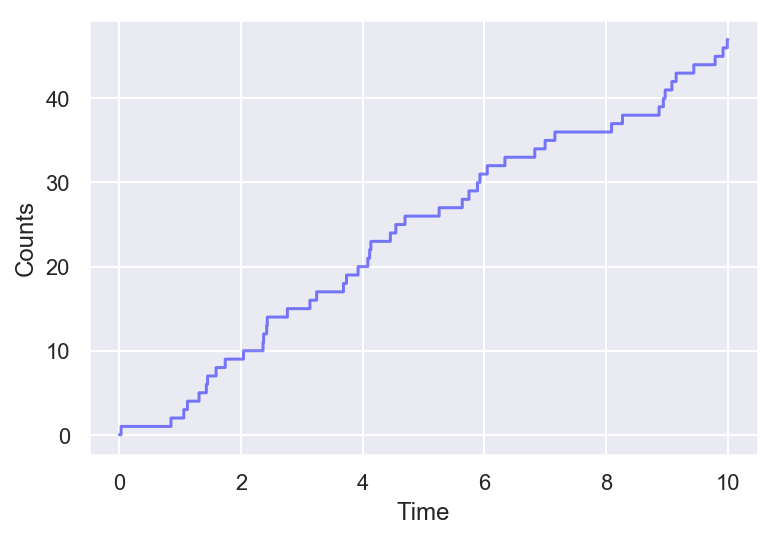

In [25]:
plt.step(bins, v.sum(axis=0).cumsum(), color='blue', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

---

In [26]:
processes = 30

income = []
for i in tqdm.tqdm(range(processes)):
    res = gen_poisson_multiple(n=10, 
                               lambda_=LAMBDA,
                               time_border=T)

    inc_v, bins = get_claims_and_bins(n=10, 
                                  time_border=T, 
                                  poisson_vecs=res,
                                  bins_multiple=100)
    
    s = inc_v.sum(axis = 0)
    income.append(s)

100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 162.15it/s]


In [27]:
outcome = []
for i in tqdm.tqdm(range(processes)):
    res = gen_poisson_multiple(n=10, 
                               lambda_=LAMBDA+0.1,
                               time_border=T)

    out_v, bins = get_claims_and_bins(n=10, 
                                  time_border=T, 
                                  poisson_vecs=res,
                                  bins_multiple=100)
    
    s = out_v.sum(axis = 0)
    outcome.append(s)

100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 163.03it/s]


In [28]:
bins.shape

(1000,)

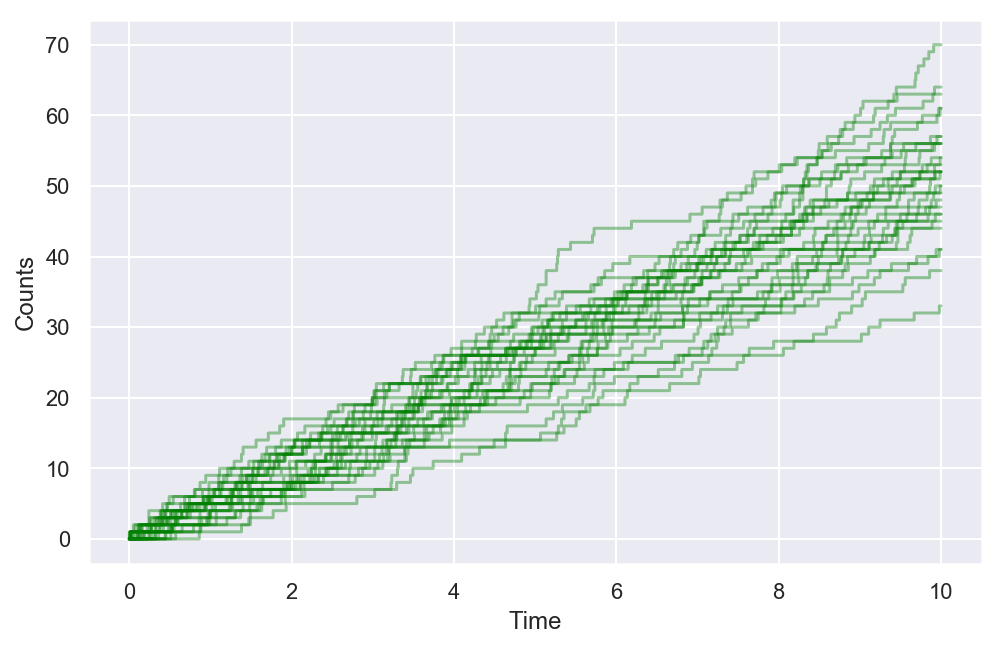

In [29]:
fig = plt.figure(figsize=(8,5))  
for v in income:
    plt.step(bins, v.cumsum(), color='green', alpha = 0.4)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

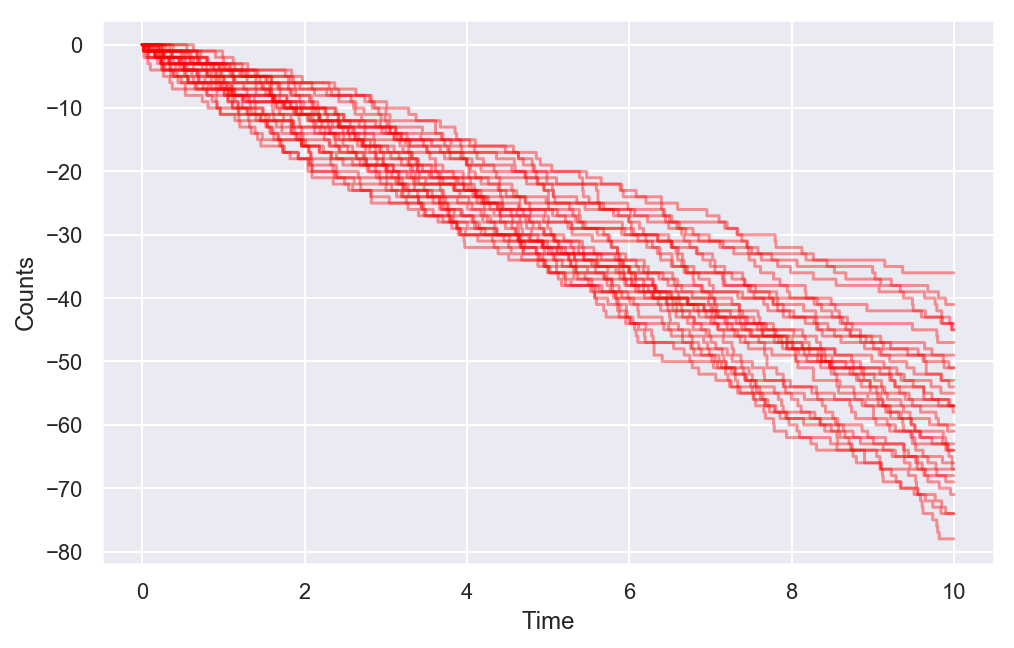

In [30]:
fig = plt.figure(figsize=(8,5))  
for v in outcome:
    plt.step(bins, -v.cumsum(), color='red', alpha = 0.4)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

In [45]:
lst = []
for v,n in zip(income, outcome):
    lst.append(v.cumsum()-n.cumsum())
lst = np.array(lst)

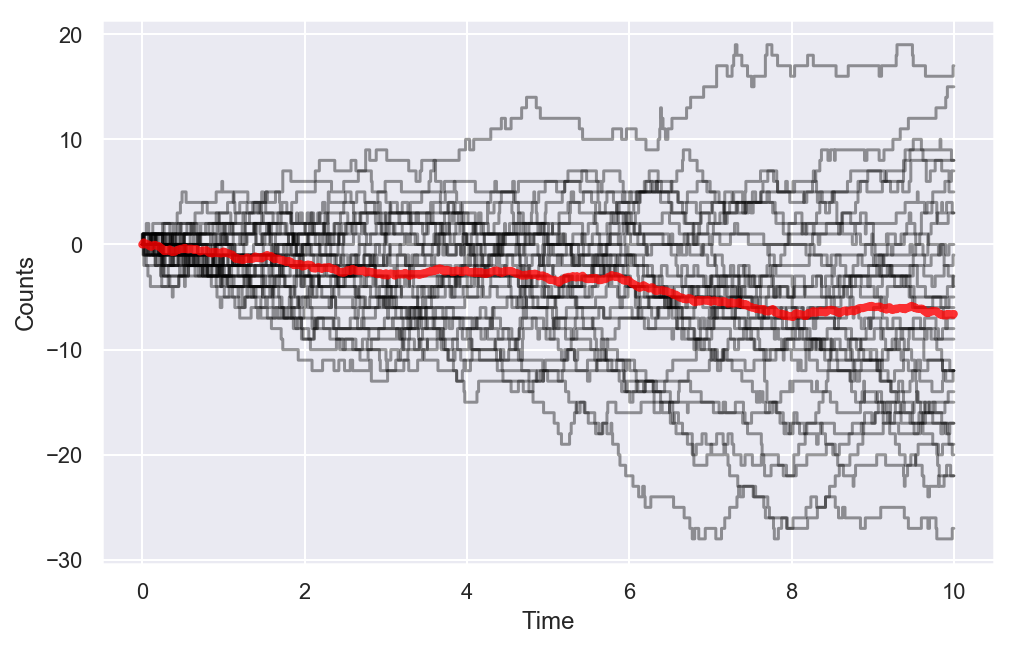

In [55]:
fig = plt.figure(figsize=(8,5))  
for v,n in zip(income, outcome):
    plt.step(bins, (v.cumsum()-n.cumsum()), color='black', alpha = 0.4)
plt.plot(bins, lst.mean(axis=0), color='red', alpha=0.8, lw=4)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()